In [26]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import RobustScaler,StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import importlib
from sklearn.decomposition import PCA

path_src = os.path.abspath('../../../src')

# Agregar esa ruta al sys.path si no está ya
if path_src not in sys.path:
    sys.path.append(path_src)

# Importar utils normalmente
import utils
importlib.reload(utils)

# Importar funciones específicas
from utils import (
    run_dbscan, 
    transform_pca,
    silhouette_analysis,
    elbow_method,
    plot_davies_bouldin_scores,
    evaluar_calinski_harabasz
)



In [27]:
rfm_cliente_local = pd.read_csv('../../../dataset/rfm_clientes_locales.csv')

print("cantidad de columnas: ", len(rfm_cliente_local.columns))

print("cantidad de filas: ", len(rfm_cliente_local))

cantidad de columnas:  18
cantidad de filas:  3915


In [28]:
def remove_outliers_iqr(df, columns):
    """
    Elimina outliers usando el método IQR (Interquartile Range)
    """
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filtramos los outliers
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    return df_clean

# Columnas a limpiar
columns_to_clean = ['Recency', 'Frequency', 'Monetary']

# Mostrar estadísticas antes de la limpieza
print("Estadísticas ANTES de la limpieza de outliers:")
print(rfm_cliente_local[columns_to_clean].describe())
print(f"\nCantidad de registros antes: {len(rfm_cliente_local)}")

# Aplicar limpieza de outliers
rfm_clientes_locales_clean = remove_outliers_iqr(rfm_cliente_local, columns_to_clean)

Estadísticas ANTES de la limpieza de outliers:
           Recency    Frequency       Monetary
count  3915.000000  3915.000000    3915.000000
mean     92.879693     4.234227    1787.280235
std      99.666473     7.155978    6834.630348
min       1.000000     1.000000       2.900000
25%      18.000000     1.000000     296.670000
50%      51.000000     2.000000     643.760000
75%     144.000000     5.000000    1563.780000
max     374.000000   206.000000  259657.300000

Cantidad de registros antes: 3915


In [29]:
id_cliente= rfm_clientes_locales_clean['id_cliente'].copy()

id_cliente.head()

3    12820.0
4    12821.0
5    12822.0
6    12823.0
7    12824.0
Name: id_cliente, dtype: float64

In [30]:
rfm_clientes_locales_clean.drop(columns=['id_cliente'], inplace=True)

In [31]:
rfm_clientes_locales_clean.columns

Index(['Recency', 'Frequency', 'Monetary', 'horario_promedio', '2010-12',
       '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12'],
      dtype='object')

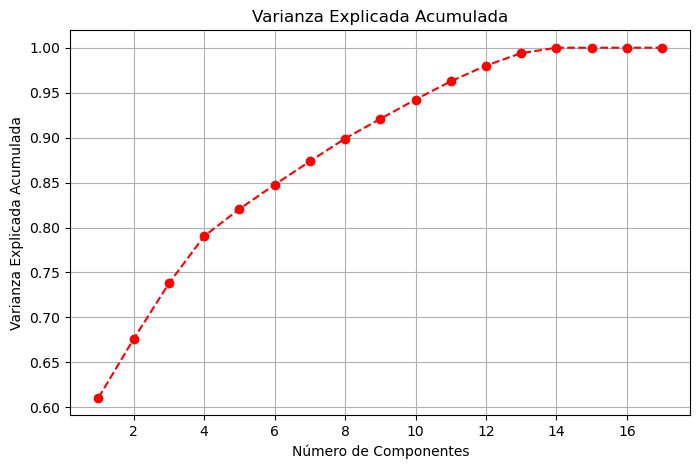

In [32]:
pca=PCA()

pca.fit(rfm_clientes_locales_clean)

var_exp=pca.explained_variance_ratio_

# Graficar varianza acumulada
plt.figure(figsize=(8,5))
plt.plot(range(1, len(var_exp)+1), var_exp.cumsum(), marker='o', linestyle='--', color='red')
plt.ylabel('Varianza Explicada Acumulada')
plt.xlabel('Número de Componentes')
plt.title('Varianza Explicada Acumulada')
plt.grid()
plt.show()

In [33]:
componentes = transform_pca(rfm_clientes_locales_clean, 5)

# dichas compoenentes la transformamos en un dataframe de pandas , con los mismos indices que el dataframe original , para hacer un analisis psoteriormente de los grupos que forma k-means
dataframe_pca = pd.DataFrame(componentes, columns=['PC1', 'PC2','PC3','PC4','PC5'],index=rfm_clientes_locales_clean.index)

dataframe_pca.head()



,PC1,PC2,PC3,PC4,PC5
3,-0.269982,-0.142595,0.017760,0.028126,0.061311
4,0.467073,0.084575,0.190151,0.003781,0.016909
5,-0.064354,-0.051997,0.000188,-0.292406,0.316180
6,-0.374178,0.265024,-0.053286,-0.122208,0.157205
7,0.113712,-0.214248,-0.068477,-0.032582,-0.064566


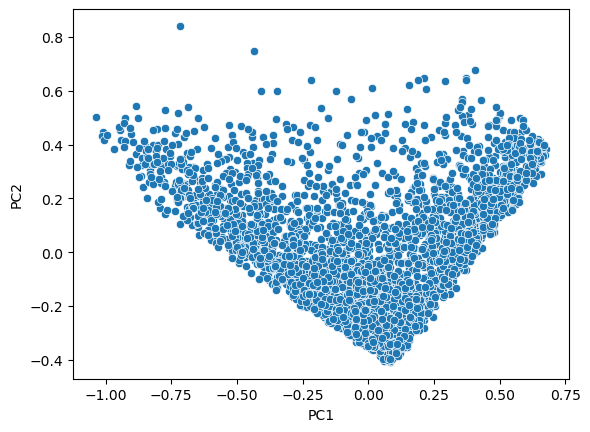

In [34]:
sns.scatterplot(x='PC1', y='PC2', data=dataframe_pca)
plt.show()

In [35]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import optuna
def objective(trial):
    eps = trial.suggest_float('eps', 0.1, 10, step=0.1)
    min_samples = trial.suggest_int('min_samples', 1, 30)

    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(dataframe_pca.values)

    # Filtrar casos con solo ruido o un único clúster
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters < 2:
        return -9999.0  # Penalización fuerte

    X = dataframe_pca.values

    silhouette = silhouette_score(dataframe_pca.values, labels)
    calinski = calinski_harabasz_score(dataframe_pca.values, labels)
    davies = davies_bouldin_score(dataframe_pca.values, labels)

    # Normalizamos CH (opcional) y restamos DB
    # Pesos: silhouette (60%), calinski (40%), davies (-20%)
    score = (
        0.6 * silhouette +
        0.4 * (calinski / 100) - 
        0.2 * davies
    )

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

print("Mejores hiperparámetros encontrados:")
print(study.best_params)

print("\nMejor puntuación compuesta obtenida:")
print(study.best_value)


[I 2025-07-14 11:00:20,385] A new study created in memory with name: no-name-e0e34f0f-347b-4fc0-a07e-5f90c8f9fc84
[I 2025-07-14 11:00:20,547] Trial 0 finished with value: -9999.0 and parameters: {'eps': 7.6, 'min_samples': 21}. Best is trial 0 with value: -9999.0.
[I 2025-07-14 11:00:20,689] Trial 1 finished with value: -9999.0 and parameters: {'eps': 4.3, 'min_samples': 25}. Best is trial 0 with value: -9999.0.
[I 2025-07-14 11:00:20,843] Trial 2 finished with value: -9999.0 and parameters: {'eps': 3.6, 'min_samples': 28}. Best is trial 0 with value: -9999.0.
[I 2025-07-14 11:00:21,160] Trial 3 finished with value: -9999.0 and parameters: {'eps': 8.5, 'min_samples': 15}. Best is trial 0 with value: -9999.0.
[I 2025-07-14 11:00:21,445] Trial 4 finished with value: -9999.0 and parameters: {'eps': 4.0, 'min_samples': 5}. Best is trial 0 with value: -9999.0.
[I 2025-07-14 11:00:21,719] Trial 5 finished with value: -9999.0 and parameters: {'eps': 6.6, 'min_samples': 11}. Best is trial 0 wi

KeyboardInterrupt: 

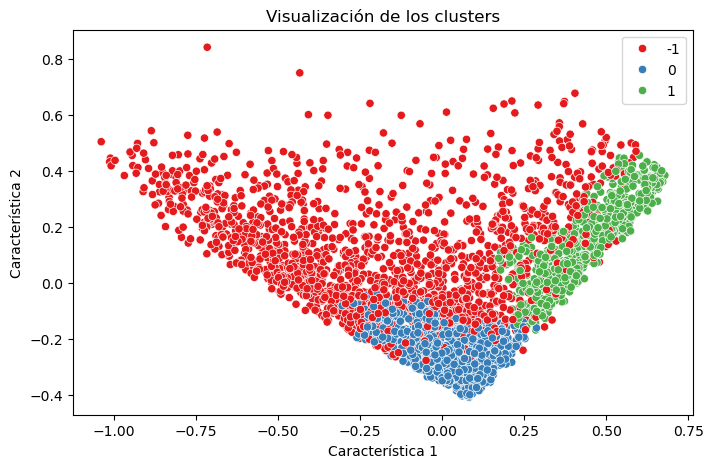

Run ID final clustering: d10feabb7d854e56a4cb5cff188d0282
🏃 View run Final_Clustering_dbscan at: http://localhost:5000/#/experiments/768548522088642905/runs/d10feabb7d854e56a4cb5cff188d0282
🧪 View experiment at: http://localhost:5000/#/experiments/768548522088642905


,PC1,PC2,PC3,PC4,PC5,Cluster
3,-0.269982,-0.142595,0.017760,0.028126,0.061311,0
4,0.467073,0.084575,0.190151,0.003781,0.016909,1
5,-0.064354,-0.051997,0.000188,-0.292406,0.316180,-1
6,-0.374178,0.265024,-0.053286,-0.122208,0.157205,-1
7,0.113712,-0.214248,-0.068477,-0.032582,-0.064566,0


In [36]:
data_clust = run_dbscan(dataframe_pca, 0.1,21,experiment_name="DBSCAN_Clientes_Locales")
data_clust.head()

In [37]:
id_cliente.index = data_clust.index

In [38]:
data_clust['id_cliente'] = id_cliente

In [39]:
data_clust = data_clust[['id_cliente', 'PC1', 'PC2','PC3','PC4','PC5', 'Cluster']]

data_clust.head()

,id_cliente,PC1,PC2,PC3,PC4,PC5,Cluster
3,12820.0,-0.269982,-0.142595,0.017760,0.028126,0.061311,0
4,12821.0,0.467073,0.084575,0.190151,0.003781,0.016909,1
5,12822.0,-0.064354,-0.051997,0.000188,-0.292406,0.316180,-1
6,12823.0,-0.374178,0.265024,-0.053286,-0.122208,0.157205,-1
7,12824.0,0.113712,-0.214248,-0.068477,-0.032582,-0.064566,0


In [40]:
rfm_clientes_locales_clean['Cluster']=data_clust['Cluster']
rfm_clientes_locales_clean['id_cliente']=id_cliente

In [41]:
rfm_clientes_locales_clean.head(10)

,Recency,Frequency,Monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,Cluster,id_cliente
3,4,4,942.34,13,0.0,170.46,0.0,0.00,0.0,0.00,0.00,0.0,0.0,217.77,343.76,0.00,210.35,0,12820.0
4,215,1,92.72,15,0.0,0.00,0.0,0.00,0.0,92.72,0.00,0.0,0.0,0.00,0.00,0.00,0.00,1,12821.0
5,71,2,948.88,13,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,948.88,0.00,0.00,0.00,-1,12822.0
6,75,5,1759.50,12,0.0,0.00,535.5,459.00,0.0,0.00,0.00,0.0,229.5,535.50,0.00,0.00,0.00,-1,12823.0
7,60,1,397.12,12,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,397.12,0.00,0.00,0,12824.0
8,3,7,1474.72,12,155.0,542.10,0.0,0.00,0.0,0.00,121.52,0.0,0.0,234.00,0.00,279.50,142.60,-1,12826.0
9,6,3,430.15,14,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,217.75,100.95,111.45,0,12827.0
10,3,6,1018.71,12,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,338.2,77.31,245.80,0.00,357.40,-1,12828.0
13,263,1,215.05,13,0.0,0.00,0.0,215.05,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,1,12831.0
14,33,2,383.03,13,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,267.80,0.00,115.23,0.00,0,12832.0


In [42]:
cluster_summary = rfm_clientes_locales_clean.groupby('Cluster').mean(numeric_only=True)
display(cluster_summary)

,Recency,Frequency,Monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,id_cliente
Cluster,,,,,,,,,,,,,,,,,,
-1,81.603106,3.911801,1216.332975,12.663354,67.633938,63.076149,66.620963,84.791130,77.863354,101.596360,77.667938,82.507311,89.435652,171.892006,132.944602,158.253391,42.050180,15517.401863
0,36.017824,1.788931,403.953490,12.687617,15.209343,5.365563,6.883330,11.967542,9.451041,13.202927,12.718255,13.016689,10.669250,30.732917,108.636745,139.081689,27.018199,15670.697936
1,223.402961,1.134868,243.805987,12.518092,3.669622,17.708668,29.412664,46.421579,34.812582,31.075066,36.620313,31.543569,12.541924,0.000000,0.000000,0.000000,0.000000,15507.694079


In [43]:
cluster_summary.columns

Index(['Recency', 'Frequency', 'Monetary', 'horario_promedio', '2010-12',
       '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       'id_cliente'],
      dtype='object')

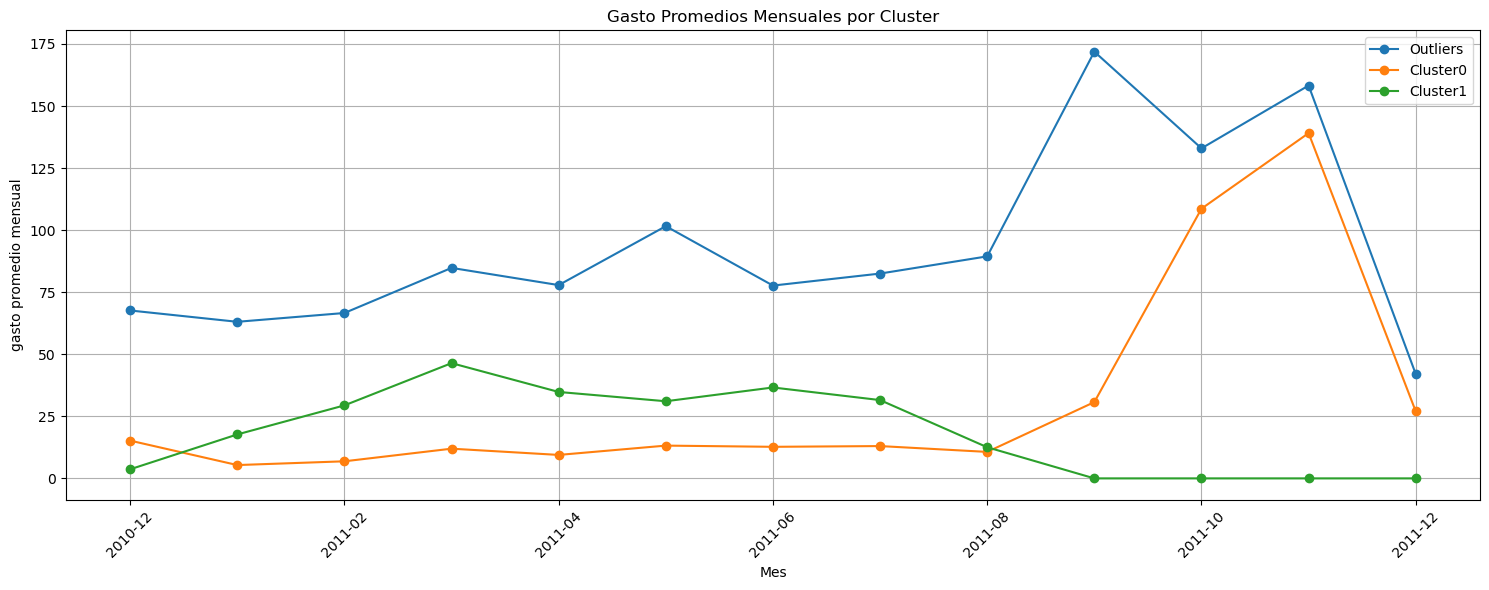

In [45]:
outliers_mes= cluster_summary.iloc[0].T
cluster0_mes= cluster_summary.iloc[1].T
cluster1_mes= cluster_summary.iloc[2].T

columnas_fechas = [col for col in rfm_clientes_locales_clean.columns if col.startswith('201')]

outliers_mes=outliers_mes[columnas_fechas]
cluster0_mes=cluster0_mes[columnas_fechas]
cluster1_mes=cluster1_mes[columnas_fechas]

ventas_promedios_mensuales=pd.concat([outliers_mes,cluster0_mes,cluster1_mes],axis=1)
ventas_promedios_mensuales.columns=['Outliers','Cluster0','Cluster1']

ventas_promedios_mensuales.plot(
    figsize=(15, 6),
    title='Gasto Promedios Mensuales por Cluster',
    marker='o' ,
    markersize=6 )

plt.xlabel("Mes")
plt.ylabel("gasto promedio mensual")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
ventas_promedios_mensuales

,Outliers,Cluster0,Cluster1
2010-12,67.633938,15.209343,3.669622
2011-01,63.076149,5.365563,17.708668
2011-02,66.620963,6.883330,29.412664
2011-03,84.791130,11.967542,46.421579
2011-04,77.863354,9.451041,34.812582
2011-05,101.596360,13.202927,31.075066
2011-06,77.667938,12.718255,36.620313
2011-07,82.507311,13.016689,31.543569
2011-08,89.435652,10.669250,12.541924
2011-09,171.892006,30.732917,0.000000


In [46]:
rfm_columnas=['Recency', 'Frequency', 'Monetary']
outliers_rfm=cluster_summary.iloc[0].T
cluster0_rfm=cluster_summary.iloc[1].T
cluster1_rfm=cluster_summary.iloc[2].T

outliers_rfm=outliers_rfm[rfm_columnas]
cluster0_rfm=cluster0_rfm[rfm_columnas]
cluster1_rfm=cluster1_rfm[rfm_columnas]

rfm_promedio_cluster=pd.concat([outliers_rfm,cluster0_rfm,cluster1_rfm],axis=1)
rfm_promedio_cluster.columns=['Outliers','Cluster 0','Cluster 1']

In [49]:
rfm_promedio_cluster

,Outliers,Cluster 0,Cluster 1
Recency,81.603106,36.017824,223.402961
Frequency,3.911801,1.788931,1.134868
Monetary,1216.332975,403.953490,243.805987


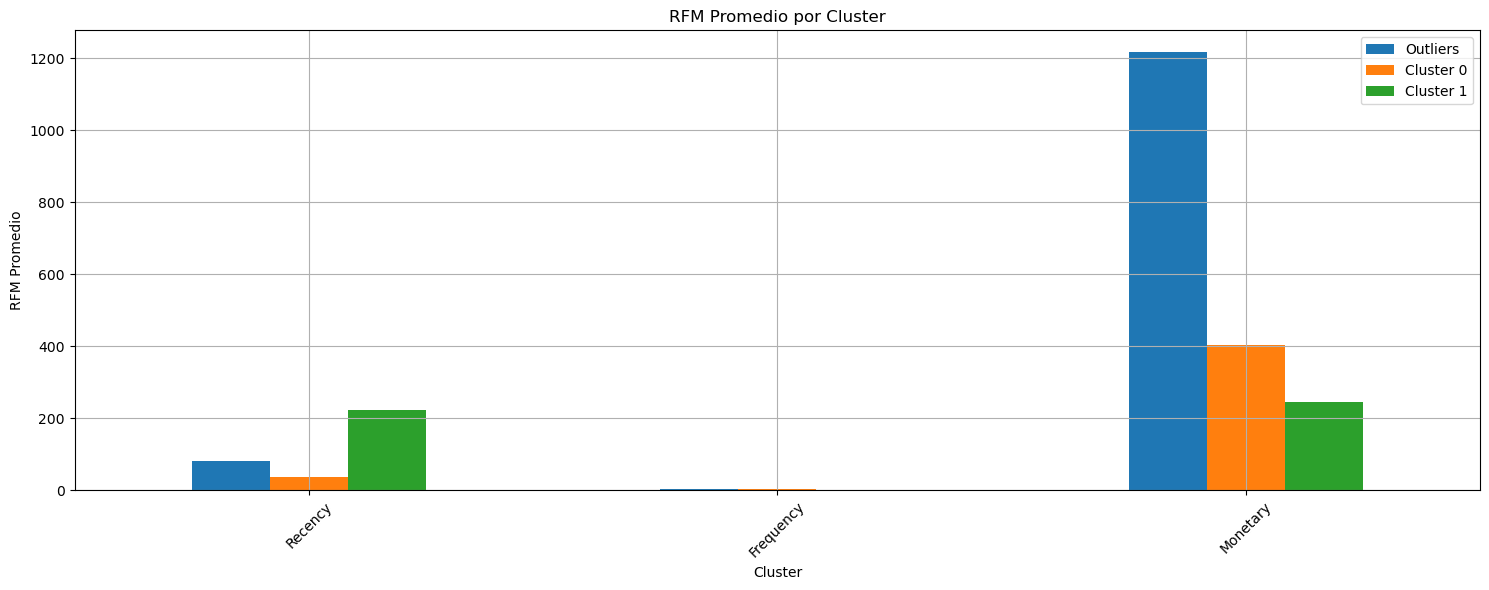

In [47]:
rfm_promedio_cluster.plot(kind='bar', figsize=(15, 6))
plt.title('RFM Promedio por Cluster')
plt.xlabel('Cluster')
plt.ylabel('RFM Promedio')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
dbscan_clientes_locales = rfm_clientes_locales_clean[['id_cliente','Cluster']]

dbscan_clientes_locales.to_csv('../../../dataset/dbscan_clientes_locales.csv',index=False)